# SpeakUp2.0: Calibration with Anipose


### Info Documents 
location repository: 
anipose documentation: https://anipose.readthedocs.io/en/latest/aniposelib-tutorial.html


### Requirements
Please install the necessary packages in requirements.txt using pip install -r requirements.txt


### CODE OVERVIEW
This script allows you to to calibrate your cameras, producing a toml file with the results of the cameras intrinsics and extrinsics angles that are needed to then further triangulate your 2D tracking. The script process multiple video files from different session, outputting the calibration results for each session. 

0. **Packages**
     The script imports essential Python libraries for file handling, video processing, and camera calibration.
     See requirements.txt for all necessary packages (pip install -r requirements.txt)

1. **Key Variables**
     Users defines the input and output directories for the calibration videos and results.
     - **Videos**  When inputing the videos, the script checks for the following requirements.
         - video_extension (e.g., "avi", "mp4", etc.)
         - number of videos in each folder (all processed together to calculate intrinsic and extrinsic angles). For Triangulation in 3D tracking, at least 3 videos are needed
         - board_type (e.g., "charuco", "checker"). This string must appear in the file name of the videos. Change or remove accordingly.

    - **Cameras**  camera_names, i.e., name for each camera that is consitent with the file name for each video (after Video Segmentation)
      
    - **Board** The script supports the use of different calibration boards, such as ChArUco or Checkerboard, to extract calibration data.
        Board Dimensions:
        - X and Y represent the number of squares in the vertical and horizontal directions on the board.
        - square_length: The side length of each square on the board, typically measured in millimeters (e.g., 25 mm). 
        - marker_length: The side length of each marker within the squares, usually smaller than the square length (e.g., 18.75 mm).
        - marker_bits: Describes the dimension of the markers, usually represented by 4x4 bits (default setting).
        - dict_size: Specifies the number of different markers in the dictionary (e.g., 50 types defaylt setting).
        !! **These parameters should be adjusted according to the specific calibration board you are using to ensure accurate camera calibration**.

2. **Calibration (with Loop)**
The script processes videos from multiple sessions to calibrate cameras and generate a .toml file containing the intrinsic and extrinsic parameters needed for 3D triangulation.
- The script iterates through subdirectories in the input folder, identifying sets of videos based on specified criteria (e.g., file extension, number of videos, and board type).
- Only directories with the correct number of videos (e.g., 3 for triangulation) and matching the specified criteria are processed.

- aniposelib to perform calibration, leveraging the ChArUco or Checkerboard configurations set by the user.
  - The CameraGroup object is created to treat all identified cameras as a unit for calibration.
  - Calibration data is calculated based on the detected board markers across multiple camera angles.
 
After calibration, the script automatically generates a filename for the results based on the input video characteristics.
The calibration results, including camera intrinsics and extrinsics, are saved as a .toml file in the specified output folder.
The saved file is structured for easy retrieval and further processing, ensuring that the calibration data is ready for use in subsequent 2D or 3D tracking tasks.

## 0. Importing Necessary Packages 

In [1]:
import os                                # Importing the os module which provides functions for interacting with the operating system
import glob                              # Importing glob module for finding files and directories matching a specified pattern
import cv2                               # Importing OpenCV library for computer vision tasks like image and video processing
import aniposelib                        # Importing aniposelib for multi-camera calibration and 3D reconstruction tasks
from aniposelib.boards import CharucoBoard, Checkerboard  # Importing specific board types for camera calibration from aniposelib
from aniposelib.cameras import Camera, CameraGroup        # Importing Camera and CameraGroup classes for handling multiple camera setups in aniposelib
from aniposelib.utils import load_pose2d_fnames           # Importing utility function for loading 2D pose filenames from aniposelib
# import table                             # Importing the table module, likely used for handling data in tabular format (usage context-dependent)


print("Everything was imported succesfully") #as terminal


## Check whether python 3.9 is necessary or the most recent version is also fine

Everything was imported succesfully


We use the following charucoboard, which when printed on a A1, gives the below dimensions you need to set for your anipose settings.
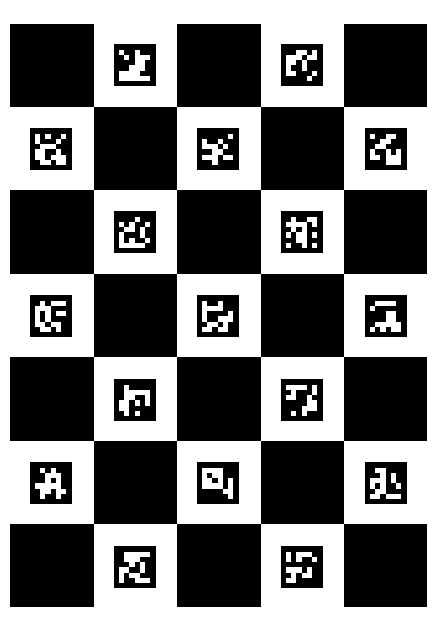


In [12]:
## Here is an example of the videos used for calibration
from IPython.display import Video
video_path = r"C:\Users\ahmar\OneDrive\Documents\GitHub\Mobile-Multimodal-Lab\2_PREPROCESSING\2_MOTION_TRACKING\2_Video Calibration\calibration_videos\charuco_calibration_oneover250s_high_quality_2024-04-23_output_compr - Trim_cam1.avi"
# Display the video
Video(video_path)

## 1. Defyining relevant Directories, Variables & Functions

In [2]:
# ---------- DIRECTORIES --------------------------
input_folder  = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split'    # input folder with the raw video files to calibrate (relative path) 
output_folder = r'Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_results'   # output folder to store the TOML results (relative path) 

print("Input folder =", os.path.abspath(input_folder))
print("Output folder =", os.path.abspath(output_folder))


# ---------- VARIABLES -------------------------
# Videos Requirements
video_extension = '.mp4'      # Video format extension avi. Change as needed (e.g., .mp4)
num_videos      = 3           # We are working with 3 complementary videos (1 original video split in 3 from the 3 camera angles) 
board_type      = "charuco"   # Change accordingly (e.g., to Checker)

keyword = 'calibration_charuco'             # keyword to filter the video files in the input folder (e.g., 'split' for the split videos

#Cameras
camera_names   = ['cam1', 'cam2', 'cam3']   # name of each camera view, consistent with video file names!!

#Board. IMPORTANT TO HAVE THE RIGHT SETTINGS - OTHERWISE THE CALIBRATION WILL NOT WORK
board = CharucoBoard(7, 5,                   #  because we had 7 squares in the vertical direction and 5 squares in the borizontal direction.
                     square_length=108,      #  dimensions of each square on the board is 108 mm
                     marker_length=85,       #  dimensions of each marker within each square is 85 mm
                     marker_bits=4,          #  each marker consists of 4x4 bits (default)   !!! WRITE IN INSTRUCTIONS. 
                     dict_size=50)           #  50 types of markers in the marker dictionary (default).


Input folder = Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split
Output folder = Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_results


## 2. Calibrating Videos using Anipose (in Loop)

In [4]:
# Iterate through each subfolder inside the input folder
for subfolder_name in os.listdir(input_folder):
    subfolder_path = os.path.join(input_folder, subfolder_name)
    
    # Check if the path is indeed a directory
    if os.path.isdir(subfolder_path):
        # Collect all video files in the subfolder
        video_files = [[os.path.join(subfolder_path, video).replace("/", "\\")] for video in os.listdir(subfolder_path) if video.endswith('.mp4')]
        
        # Debug output to ensure paths are correct
        print(f'Processing videos from folder: {subfolder_path}')

        print(f'I have identified the following video files that will be the input for ANIPOSE: {video_files}')    ### MAKE SURE THE VIDEOS ARE STORE IN A LIST OF LIST FOR ANIPOSE TO WORK (Not a Flat List)
        
        # Check if the number of collected videos is correct
        if len(video_files) == num_videos:
            print("Next step: Calibration")
            
            # Proceed with the calibration process using the collected video files
            try:
                cgroup = CameraGroup.from_names(camera_names)  # Object for camera group
                cgroup.calibrate_videos(video_files, board)    # Calibration of videos
            except FileNotFoundError as e:
                print(f"File not found error: {e}")
                print("Please check if the paths are correct and the files exist.")
                continue
            
            # Saving the calibration output
                # Make sure calibration folder exist, if not create it
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
                

            output_name = f'{num_videos}vid_{os.path.basename(subfolder_name)}_calibration_anipose.toml'
            print(f"Saving {output_name}")
            cgroup.dump(os.path.join(output_folder, output_name))  # Saving calibration results
            
            print(f"Calibration complete for folder: {subfolder_path}\n")

        else:
            print(f"ERROR: {subfolder_path} does not contain exactly {num_videos} videos.\n")
            
print("Calibration process completed. You can now check the results at in the output folder.", output_folder) 


Processing videos from folder: Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_01_d2_calibration_charuco
I have identified the following video files that will be the input for ANIPOSE: [['Z:\\Davide_MultimodalLab\\3_DATA_ANALYSIS\\1_MOTION_TRACKING\\2_Video_Calibration\\calibration_charuco_split\\pilot_01_d2_calibration_charuco\\pilot_01_d2_calibration_charuco_cam1.mp4'], ['Z:\\Davide_MultimodalLab\\3_DATA_ANALYSIS\\1_MOTION_TRACKING\\2_Video_Calibration\\calibration_charuco_split\\pilot_01_d2_calibration_charuco\\pilot_01_d2_calibration_charuco_cam2.mp4'], ['Z:\\Davide_MultimodalLab\\3_DATA_ANALYSIS\\1_MOTION_TRACKING\\2_Video_Calibration\\calibration_charuco_split\\pilot_01_d2_calibration_charuco\\pilot_01_d2_calibration_charuco_cam3.mp4']]
Next step: Calibration
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_01_d2_calibration_charuco\pilot_01_d2_calibration_ch

100%|█████████████████████████████| 1537/1537 [00:39<00:00, 39.15it/s]


1536 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_01_d2_calibration_charuco\pilot_01_d2_calibration_charuco_cam2.mp4


100%|█████████████████████████████| 1537/1537 [00:27<00:00, 55.57it/s]


1537 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_01_d2_calibration_charuco\pilot_01_d2_calibration_charuco_cam3.mp4


100%|█████████████████████████████| 1537/1537 [00:35<00:00, 42.97it/s]


1537 boards detected
[{'name': 'cam1', 'size': [540, 960], 'matrix': [[655.1529593333228, 0.0, 269.5], [0.0, 655.1529593333228, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam2', 'size': [540, 960], 'matrix': [[671.5799799150789, 0.0, 269.5], [0.0, 671.5799799150789, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam3', 'size': [540, 960], 'matrix': [[665.2554416426664, 0.0, 269.5], [0.0, 665.2554416426664, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>,
            {('cam1', 'cam2'): 1520,
             ('cam1', 'cam3'): 1520,
             ('cam2', 'cam1'): 1520,
             ('cam2', 'cam3'): 1537,
             ('cam3', 'cam1'): 1520,
             ('cam3', 'cam2'): 1537})
error:  0.4312848623

100%|███████████████████████████████| 741/741 [00:19<00:00, 38.61it/s]


739 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_01_d3_calibration_charuco\pilot_01_d3_calibration_charuco_cam2.mp4


100%|███████████████████████████████| 741/741 [00:13<00:00, 56.00it/s]


741 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_01_d3_calibration_charuco\pilot_01_d3_calibration_charuco_cam3.mp4


100%|███████████████████████████████| 741/741 [00:18<00:00, 40.61it/s]


741 boards detected
[{'name': 'cam1', 'size': [540, 960], 'matrix': [[660.2367315941405, 0.0, 269.5], [0.0, 660.2367315941405, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam2', 'size': [540, 960], 'matrix': [[673.2487429452929, 0.0, 269.5], [0.0, 673.2487429452929, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam3', 'size': [540, 960], 'matrix': [[660.2064619724749, 0.0, 269.5], [0.0, 660.2064619724749, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>,
            {('cam1', 'cam2'): 731,
             ('cam1', 'cam3'): 731,
             ('cam2', 'cam1'): 731,
             ('cam2', 'cam3'): 741,
             ('cam3', 'cam1'): 731,
             ('cam3', 'cam2'): 741})
error:  0.4102407042591835


100%|█████████████████████████████| 1377/1377 [00:35<00:00, 38.75it/s]


1319 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_02_d2_calibration_charuco\pilot_02_d2_calibration_charuco_cam2.mp4


100%|█████████████████████████████| 1377/1377 [00:24<00:00, 55.33it/s]


1377 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_02_d2_calibration_charuco\pilot_02_d2_calibration_charuco_cam3.mp4


100%|█████████████████████████████| 1377/1377 [00:37<00:00, 36.92it/s]


1376 boards detected
[{'name': 'cam1', 'size': [540, 960], 'matrix': [[561.3307687086574, 0.0, 269.5], [0.0, 561.3307687086574, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam2', 'size': [540, 960], 'matrix': [[553.6346287362716, 0.0, 269.5], [0.0, 553.6346287362716, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam3', 'size': [540, 960], 'matrix': [[608.9307920686141, 0.0, 269.5], [0.0, 608.9307920686141, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>,
            {('cam1', 'cam2'): 1296,
             ('cam1', 'cam3'): 1291,
             ('cam2', 'cam1'): 1296,
             ('cam2', 'cam3'): 1372,
             ('cam3', 'cam1'): 1291,
             ('cam3', 'cam2'): 1372})
error:  0.6236996838

100%|█████████████████████████████| 1300/1300 [00:27<00:00, 47.59it/s]


1236 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_02_d3_calibration_charuco\pilot_02_d3_calibration_charuco_cam2.mp4


100%|█████████████████████████████| 1300/1300 [00:23<00:00, 55.43it/s]


1300 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_02_d3_calibration_charuco\pilot_02_d3_calibration_charuco_cam3.mp4


100%|█████████████████████████████| 1300/1300 [00:36<00:00, 35.31it/s]


1300 boards detected
[{'name': 'cam1', 'size': [540, 960], 'matrix': [[665.357551998032, 0.0, 269.5], [0.0, 665.357551998032, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam2', 'size': [540, 960], 'matrix': [[672.6915964163461, 0.0, 269.5], [0.0, 672.6915964163461, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam3', 'size': [540, 960], 'matrix': [[678.6124134744721, 0.0, 269.5], [0.0, 678.6124134744721, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>,
            {('cam1', 'cam2'): 1058,
             ('cam1', 'cam3'): 1042,
             ('cam2', 'cam1'): 1058,
             ('cam2', 'cam3'): 1284,
             ('cam3', 'cam1'): 1042,
             ('cam3', 'cam2'): 1284})
error:  0.845582637364

100%|█████████████████████████████| 1079/1079 [00:21<00:00, 51.36it/s]


724 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_04_d2_calibration_charuco\pilot_04_d2_calibration_charuco_cam2.mp4


100%|█████████████████████████████| 1079/1079 [00:18<00:00, 59.33it/s]


967 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_04_d2_calibration_charuco\pilot_04_d2_calibration_charuco_cam3.mp4


100%|█████████████████████████████| 1079/1079 [00:28<00:00, 38.04it/s]


1046 boards detected
[{'name': 'cam1', 'size': [540, 960], 'matrix': [[665.0490225377309, 0.0, 269.5], [0.0, 665.0490225377309, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam2', 'size': [540, 960], 'matrix': [[657.6620840821577, 0.0, 269.5], [0.0, 657.6620840821577, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam3', 'size': [540, 960], 'matrix': [[695.1946360539482, 0.0, 269.5], [0.0, 695.1946360539482, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>,
            {('cam1', 'cam2'): 711,
             ('cam1', 'cam3'): 672,
             ('cam2', 'cam1'): 711,
             ('cam2', 'cam3'): 917,
             ('cam3', 'cam1'): 672,
             ('cam3', 'cam2'): 917})
error:  0.670087386977454


100%|█████████████████████████████| 2201/2201 [00:58<00:00, 37.64it/s]


2201 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_05_d2_calibration_charuco\pilot_05_d2_calibration_charuco_cam2.mp4


100%|█████████████████████████████| 2201/2201 [00:38<00:00, 56.70it/s]


2201 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_05_d2_calibration_charuco\pilot_05_d2_calibration_charuco_cam3.mp4


100%|█████████████████████████████| 2201/2201 [00:53<00:00, 41.06it/s]


2111 boards detected
[{'name': 'cam1', 'size': [540, 960], 'matrix': [[610.136974162515, 0.0, 269.5], [0.0, 610.136974162515, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam2', 'size': [540, 960], 'matrix': [[619.3456301075256, 0.0, 269.5], [0.0, 619.3456301075256, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam3', 'size': [540, 960], 'matrix': [[633.6060965308945, 0.0, 269.5], [0.0, 633.6060965308945, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>,
            {('cam1', 'cam2'): 2201,
             ('cam1', 'cam3'): 2085,
             ('cam2', 'cam1'): 2201,
             ('cam2', 'cam3'): 2085,
             ('cam3', 'cam1'): 2085,
             ('cam3', 'cam2'): 2085})
error:  0.513452525076

100%|█████████████████████████████| 2163/2163 [00:53<00:00, 40.23it/s]


2163 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_06_d2_calibration_charuco\pilot_06_d2_calibration_charuco_cam2.mp4


100%|█████████████████████████████| 2163/2163 [00:37<00:00, 57.70it/s]


2163 boards detected
Z:\Davide_MultimodalLab\3_DATA_ANALYSIS\1_MOTION_TRACKING\2_Video_Calibration\calibration_charuco_split\pilot_06_d2_calibration_charuco\pilot_06_d2_calibration_charuco_cam3.mp4


100%|█████████████████████████████| 2163/2163 [00:53<00:00, 40.33it/s]


2157 boards detected
[{'name': 'cam1', 'size': [540, 960], 'matrix': [[636.0284640796275, 0.0, 269.5], [0.0, 636.0284640796275, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam2', 'size': [540, 960], 'matrix': [[646.8280504102718, 0.0, 269.5], [0.0, 646.8280504102718, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'cam3', 'size': [540, 960], 'matrix': [[649.9184338240066, 0.0, 269.5], [0.0, 649.9184338240066, 479.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>,
            {('cam1', 'cam2'): 2156,
             ('cam1', 'cam3'): 2147,
             ('cam2', 'cam1'): 2156,
             ('cam2', 'cam3'): 2154,
             ('cam3', 'cam1'): 2147,
             ('cam3', 'cam2'): 2154})
error:  0.3674796362